# 11 - Final Benchmark Report

Comprehensive benchmark of all models across all time granularities.

**Models:**
- SARIMA (Statistical baseline)
- Prophet (Facebook's time series model)
- LightGBM (Gradient boosting)

**Granularities:**
- 1-minute
- 5-minute
- 15-minute

**Metrics:**
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- R2 Score

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Project imports
from src.utils.metrics import evaluate_forecast
from src.models.prophet_model import ProphetModel
from src.models.lgbm_model import LGBMModel
from src.models.sarima import SARIMAModel

# Paths
DATA_DIR = project_root / 'DATA' / 'processed'
MODELS_DIR = project_root / 'models'
REPORTS_DIR = project_root / 'reports'

plt.style.use('seaborn-v0_8-whitegrid')
print(f"Project root: {project_root}")
print(f"Benchmark started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Importing plotly failed. Interactive plots will not work.


Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow
Benchmark started at: 2026-02-02 13:38:44


## 1. Load All Datasets

In [2]:
# Load all granularities
datasets = {}

for granularity in ['1m', '5m', '15m']:
    train_path = DATA_DIR / f'train_{granularity}.parquet'
    test_path = DATA_DIR / f'test_{granularity}.parquet'
    
    if train_path.exists() and test_path.exists():
        datasets[granularity] = {
            'train': pd.read_parquet(train_path),
            'test': pd.read_parquet(test_path)
        }
        print(f"Loaded {granularity}: Train {datasets[granularity]['train'].shape}, Test {datasets[granularity]['test'].shape}")
    else:
        print(f"Missing data for {granularity}")

# Also load feature-engineered 5m data
if (DATA_DIR / 'train_features_5m.parquet').exists():
    datasets['5m_features'] = {
        'train': pd.read_parquet(DATA_DIR / 'train_features_5m.parquet'),
        'test': pd.read_parquet(DATA_DIR / 'test_features_5m.parquet')
    }
    print(f"Loaded 5m_features: Train {datasets['5m_features']['train'].shape}, Test {datasets['5m_features']['test'].shape}")

Loaded 1m: Train (76320, 11), Test (12960, 11)
Loaded 5m: Train (15264, 11), Test (2592, 11)
Loaded 15m: Train (5088, 11), Test (864, 11)
Loaded 5m_features: Train (15264, 98), Test (2592, 98)


## 2. Define Benchmark Functions

In [3]:
def train_and_evaluate_prophet(train_df, test_df, granularity):
    """Train Prophet and evaluate on test set."""
    try:
        # Prepare data for Prophet
        train_prophet = train_df[['timestamp', 'request_count']].rename(
            columns={'timestamp': 'ds', 'request_count': 'y'}
        )
        
        # Train Prophet
        model = ProphetModel()
        model.fit(train_prophet)
        
        # Predict
        future = test_df[['timestamp']].rename(columns={'timestamp': 'ds'})
        predictions = model.predict(future)['yhat'].values
        
        # Evaluate
        y_true = test_df['request_count'].values
        metrics = evaluate_forecast(y_true, predictions, name='Prophet')
        metrics['granularity'] = granularity
        
        return metrics, predictions
    except Exception as e:
        print(f"Prophet error ({granularity}): {e}")
        return None, None


def train_and_evaluate_sarima(train_df, test_df, granularity):
    """Train SARIMA and evaluate on test set."""
    try:
        # Use request_count series
        train_series = train_df['request_count'].values
        
        # Train SARIMA with appropriate seasonal period
        seasonal_periods = {'1m': 60, '5m': 12, '15m': 4}  # hourly seasonality
        period = seasonal_periods.get(granularity, 12)
        
        model = SARIMAModel(order=(1, 1, 1), seasonal_order=(1, 1, 1, period))
        model.fit(train_series)
        
        # Predict
        predictions = model.predict(steps=len(test_df))
        
        # Evaluate
        y_true = test_df['request_count'].values
        metrics = evaluate_forecast(y_true, predictions, name='SARIMA')
        metrics['granularity'] = granularity
        
        return metrics, predictions
    except Exception as e:
        print(f"SARIMA error ({granularity}): {e}")
        return None, None


def train_and_evaluate_lgbm(train_df, test_df, granularity, feature_cols=None):
    """Train LightGBM and evaluate on test set."""
    try:
        # Determine feature columns
        if feature_cols is None:
            # Use basic features if no feature columns provided
            numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
            feature_cols = [c for c in numeric_cols if c != 'request_count']
        
        # Prepare data
        X_train = train_df[feature_cols].fillna(0)
        y_train = train_df['request_count']
        X_test = test_df[feature_cols].fillna(0)
        y_test = test_df['request_count']
        
        # Train LightGBM
        model = LGBMModel()
        model.fit(X_train, y_train)
        
        # Predict
        predictions = model.predict(X_test)
        
        # Evaluate
        metrics = evaluate_forecast(y_test.values, predictions, name='LightGBM')
        metrics['granularity'] = granularity
        
        return metrics, predictions
    except Exception as e:
        print(f"LightGBM error ({granularity}): {e}")
        return None, None

## 3. Run Benchmarks

In [4]:
# Store all results
all_results = []
predictions_store = {}

print("="*70)
print("RUNNING COMPREHENSIVE BENCHMARKS")
print("="*70)

for granularity in ['1m', '5m', '15m']:
    if granularity not in datasets:
        continue
    
    print(f"\n{'='*50}")
    print(f"Benchmarking: {granularity}")
    print(f"{'='*50}")
    
    train_df = datasets[granularity]['train']
    test_df = datasets[granularity]['test']
    
    predictions_store[granularity] = {'actual': test_df['request_count'].values}
    
    # Prophet
    print("\nTraining Prophet...")
    prophet_metrics, prophet_pred = train_and_evaluate_prophet(train_df, test_df, granularity)
    if prophet_metrics:
        all_results.append(prophet_metrics)
        predictions_store[granularity]['prophet'] = prophet_pred
        print(f"  Prophet RMSE: {prophet_metrics['rmse']:.2f}")
    
    # SARIMA (skip for 1m due to computation time)
    if granularity != '1m':
        print("\nTraining SARIMA...")
        sarima_metrics, sarima_pred = train_and_evaluate_sarima(train_df, test_df, granularity)
        if sarima_metrics:
            all_results.append(sarima_metrics)
            predictions_store[granularity]['sarima'] = sarima_pred
            print(f"  SARIMA RMSE: {sarima_metrics['rmse']:.2f}")
    else:
        print("\nSkipping SARIMA for 1m (too slow)")
    
    # LightGBM (only for 5m with features)
    if granularity == '5m' and '5m_features' in datasets:
        print("\nTraining LightGBM (with features)...")
        train_feat = datasets['5m_features']['train']
        test_feat = datasets['5m_features']['test']
        
        # Load feature names
        try:
            with open(MODELS_DIR / 'feature_names.json', 'r') as f:
                feature_cols = json.load(f)
        except:
            feature_cols = None
        
        lgbm_metrics, lgbm_pred = train_and_evaluate_lgbm(train_feat, test_feat, granularity, feature_cols)
        if lgbm_metrics:
            all_results.append(lgbm_metrics)
            predictions_store[granularity]['lgbm'] = lgbm_pred
            print(f"  LightGBM RMSE: {lgbm_metrics['rmse']:.2f}")

print("\n" + "="*70)
print("BENCHMARKS COMPLETED")
print("="*70)

RUNNING COMPREHENSIVE BENCHMARKS

Benchmarking: 1m

Training Prophet...
Fitting Prophet model...


13:38:48 - cmdstanpy - INFO - Chain [1] start processing
13:39:24 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully
Prophet error (1m): Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

Skipping SARIMA for 1m (too slow)

Benchmarking: 5m

Training Prophet...
Fitting Prophet model...


13:39:25 - cmdstanpy - INFO - Chain [1] start processing
13:39:31 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully
Prophet error (5m): Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

Training SARIMA...
SARIMA error (5m): SARIMAModel.__init__() got an unexpected keyword argument 'order'

Training LightGBM (with features)...
  LightGBM RMSE: 3.19

Benchmarking: 15m

Training Prophet...
Fitting Prophet model...


13:39:37 - cmdstanpy - INFO - Chain [1] start processing
13:39:38 - cmdstanpy - INFO - Chain [1] done processing


Model fitted successfully
Prophet error (15m): Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

Training SARIMA...
SARIMA error (15m): SARIMAModel.__init__() got an unexpected keyword argument 'order'

BENCHMARKS COMPLETED


## 4. Results Summary

In [5]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Reorder columns
cols_order = ['granularity', 'model', 'rmse', 'mae', 'mape', 'r2']
cols_available = [c for c in cols_order if c in results_df.columns]
results_df = results_df[cols_available]

# Sort by granularity and RMSE
results_df = results_df.sort_values(['granularity', 'rmse'])

print("\n" + "="*80)
print("FINAL BENCHMARK RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


FINAL BENCHMARK RESULTS
granularity    model     rmse      mae     mape       r2
         5m LightGBM 3.193124 1.945759 1.164641 0.999322


In [6]:
# Save to CSV
results_path = REPORTS_DIR / 'benchmark_results.csv'
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to: {results_path}")

# Also save as JSON for API consumption
results_json = results_df.to_dict(orient='records')
with open(REPORTS_DIR / 'benchmark_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)
print(f"JSON saved to: {REPORTS_DIR / 'benchmark_results.json'}")


Results saved to: c:\Users\Admin\OneDrive\Documents\python\datafollow\reports\benchmark_results.csv
JSON saved to: c:\Users\Admin\OneDrive\Documents\python\datafollow\reports\benchmark_results.json


## 5. Visualizations

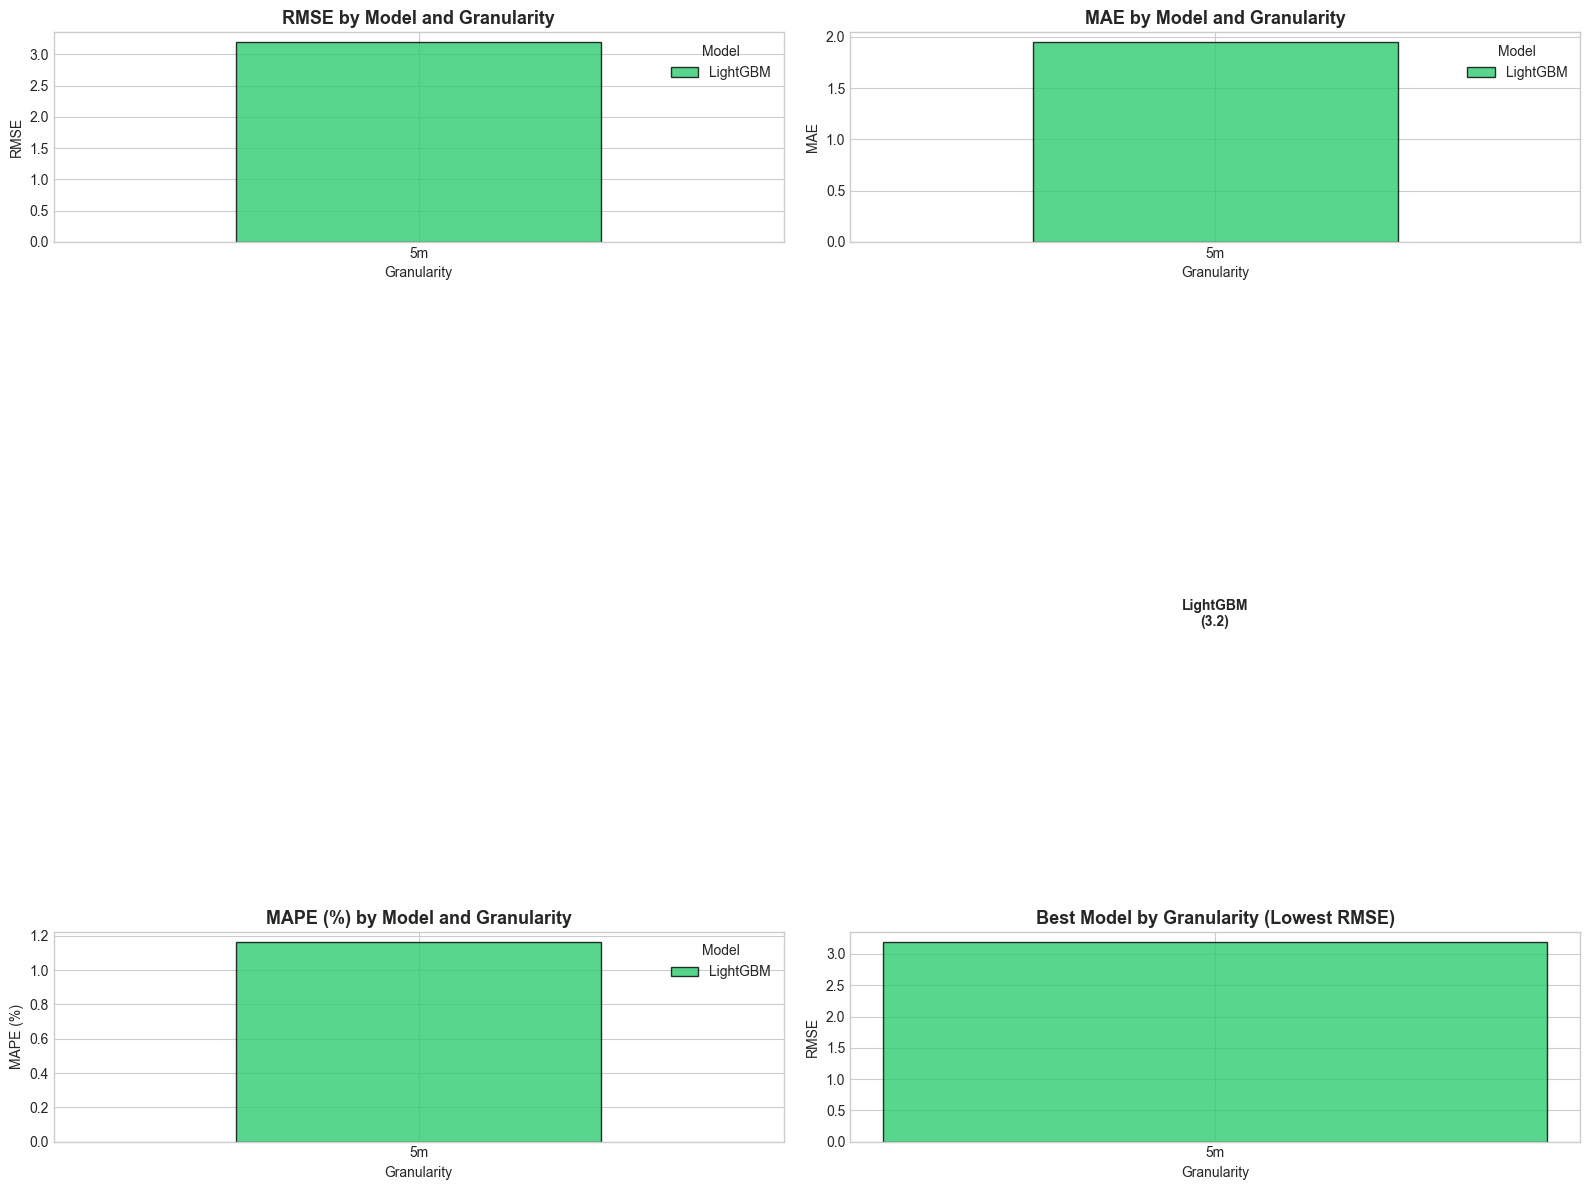


Figure saved to: reports/figures/benchmark_comparison.png


In [7]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color palette
colors = {'Prophet': '#A23B72', 'SARIMA': '#F18F01', 'LightGBM': '#2ECC71'}

# 1. RMSE by Model and Granularity
ax = axes[0, 0]
pivot_rmse = results_df.pivot(index='granularity', columns='model', values='rmse')
pivot_rmse.plot(kind='bar', ax=ax, color=[colors.get(c, '#2E86AB') for c in pivot_rmse.columns], alpha=0.8, edgecolor='black')
ax.set_title('RMSE by Model and Granularity', fontsize=13, fontweight='bold')
ax.set_xlabel('Granularity')
ax.set_ylabel('RMSE')
ax.legend(title='Model')
ax.tick_params(axis='x', rotation=0)

# 2. MAE by Model and Granularity
ax = axes[0, 1]
pivot_mae = results_df.pivot(index='granularity', columns='model', values='mae')
pivot_mae.plot(kind='bar', ax=ax, color=[colors.get(c, '#2E86AB') for c in pivot_mae.columns], alpha=0.8, edgecolor='black')
ax.set_title('MAE by Model and Granularity', fontsize=13, fontweight='bold')
ax.set_xlabel('Granularity')
ax.set_ylabel('MAE')
ax.legend(title='Model')
ax.tick_params(axis='x', rotation=0)

# 3. MAPE by Model and Granularity
ax = axes[1, 0]
pivot_mape = results_df.pivot(index='granularity', columns='model', values='mape')
pivot_mape.plot(kind='bar', ax=ax, color=[colors.get(c, '#2E86AB') for c in pivot_mape.columns], alpha=0.8, edgecolor='black')
ax.set_title('MAPE (%) by Model and Granularity', fontsize=13, fontweight='bold')
ax.set_xlabel('Granularity')
ax.set_ylabel('MAPE (%)')
ax.legend(title='Model')
ax.tick_params(axis='x', rotation=0)

# 4. Best Model Summary
ax = axes[1, 1]
best_by_granularity = results_df.loc[results_df.groupby('granularity')['rmse'].idxmin()]
bars = ax.bar(best_by_granularity['granularity'], best_by_granularity['rmse'], 
              color=[colors.get(m, '#2E86AB') for m in best_by_granularity['model']], 
              alpha=0.8, edgecolor='black')
ax.set_title('Best Model by Granularity (Lowest RMSE)', fontsize=13, fontweight='bold')
ax.set_xlabel('Granularity')
ax.set_ylabel('RMSE')

# Add model labels
for bar, model, rmse in zip(bars, best_by_granularity['model'], best_by_granularity['rmse']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{model}\n({rmse:.1f})', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'figures' / 'benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: reports/figures/benchmark_comparison.png")

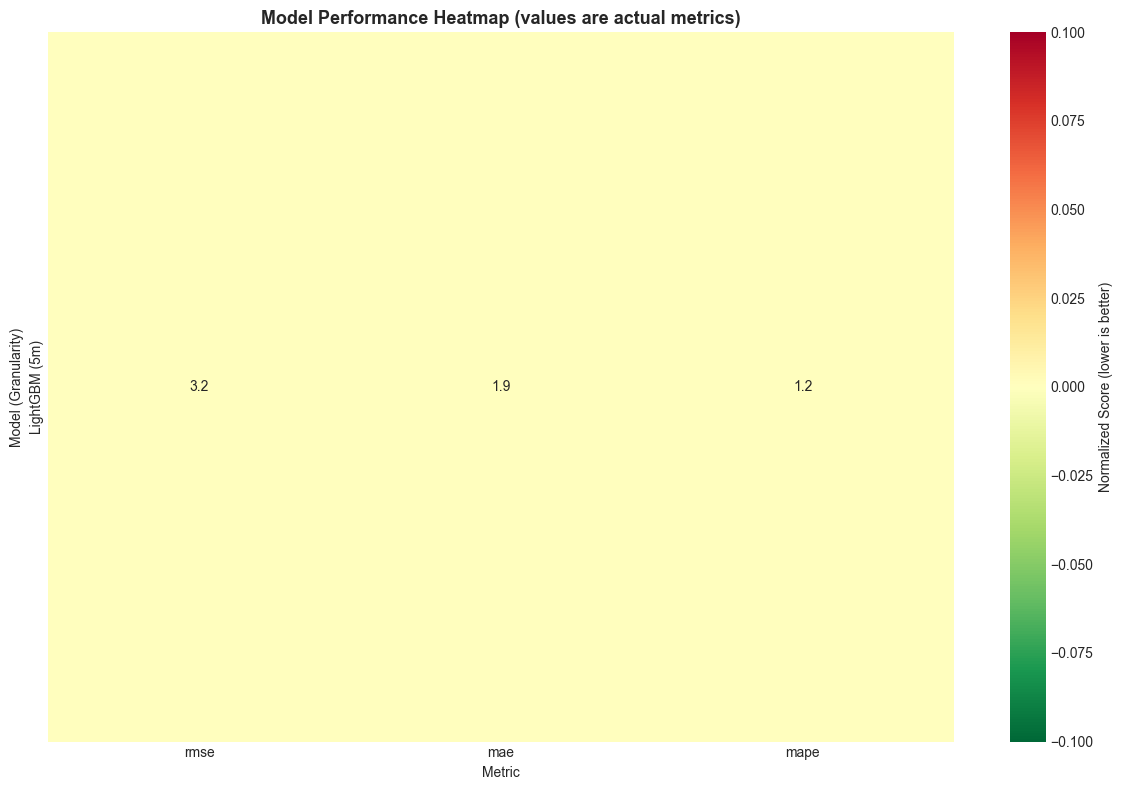

In [8]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = results_df.copy()
heatmap_data['model_gran'] = heatmap_data['model'] + ' (' + heatmap_data['granularity'] + ')'
heatmap_data = heatmap_data.set_index('model_gran')[['rmse', 'mae', 'mape']]

# Normalize for better visualization
heatmap_normalized = heatmap_data.apply(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10))

sns.heatmap(heatmap_normalized, annot=heatmap_data.values, fmt='.1f', 
            cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'Normalized Score (lower is better)'})
ax.set_title('Model Performance Heatmap (values are actual metrics)', fontsize=13, fontweight='bold')
ax.set_xlabel('Metric')
ax.set_ylabel('Model (Granularity)')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'figures' / 'benchmark_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Predictions Visualization (5-minute)

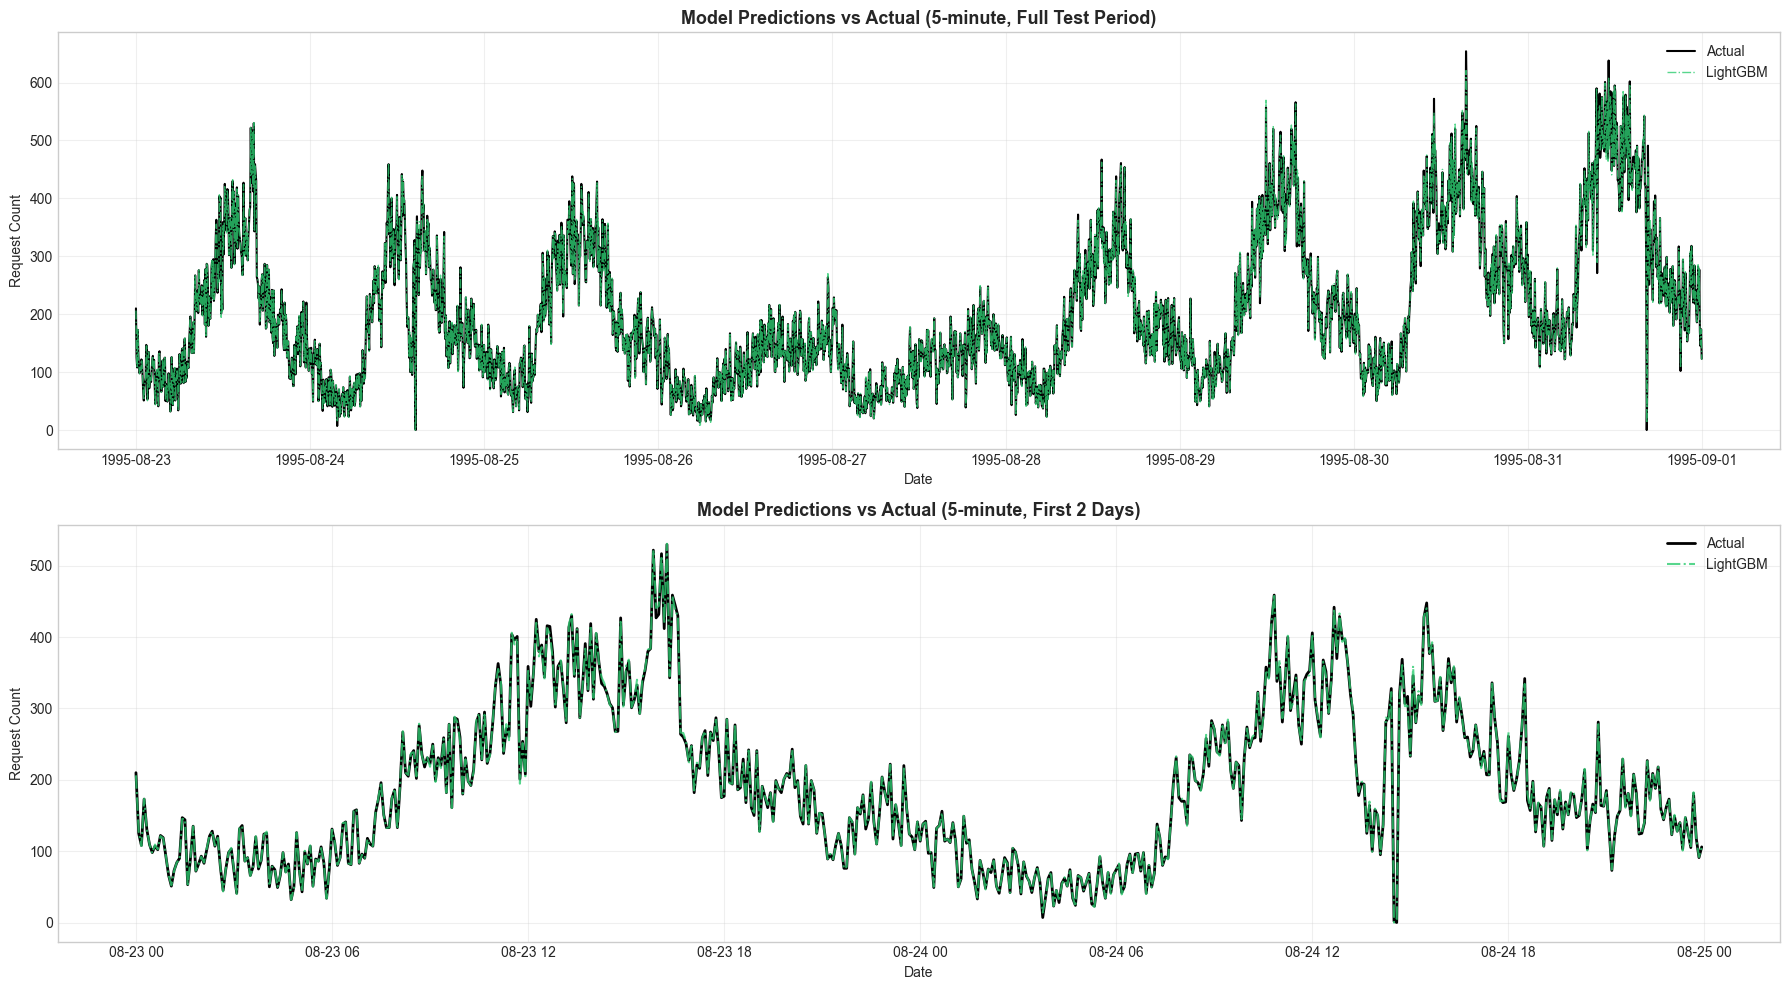

In [9]:
# Plot predictions for 5-minute data
if '5m' in predictions_store:
    pred_5m = predictions_store['5m']
    test_5m = datasets['5m']['test']
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Full period
    ax = axes[0]
    ax.plot(test_5m['timestamp'], pred_5m['actual'], label='Actual', color='black', linewidth=1.5)
    
    if 'prophet' in pred_5m:
        ax.plot(test_5m['timestamp'], pred_5m['prophet'], label='Prophet', 
                color='#A23B72', linewidth=1, linestyle='--', alpha=0.8)
    if 'sarima' in pred_5m:
        ax.plot(test_5m['timestamp'], pred_5m['sarima'], label='SARIMA', 
                color='#F18F01', linewidth=1, linestyle=':', alpha=0.8)
    if 'lgbm' in pred_5m:
        ax.plot(test_5m['timestamp'], pred_5m['lgbm'], label='LightGBM', 
                color='#2ECC71', linewidth=1, linestyle='-.', alpha=0.8)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Request Count')
    ax.set_title('Model Predictions vs Actual (5-minute, Full Test Period)', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Zoomed (first 2 days)
    ax = axes[1]
    n_points = 288 * 2  # 2 days
    ax.plot(test_5m['timestamp'].iloc[:n_points], pred_5m['actual'][:n_points], 
            label='Actual', color='black', linewidth=2)
    
    if 'prophet' in pred_5m:
        ax.plot(test_5m['timestamp'].iloc[:n_points], pred_5m['prophet'][:n_points], 
                label='Prophet', color='#A23B72', linewidth=1.5, linestyle='--', alpha=0.8)
    if 'sarima' in pred_5m:
        ax.plot(test_5m['timestamp'].iloc[:n_points], pred_5m['sarima'][:n_points], 
                label='SARIMA', color='#F18F01', linewidth=1.5, linestyle=':', alpha=0.8)
    if 'lgbm' in pred_5m:
        ax.plot(test_5m['timestamp'].iloc[:n_points], pred_5m['lgbm'][:n_points], 
                label='LightGBM', color='#2ECC71', linewidth=1.5, linestyle='-.', alpha=0.8)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Request Count')
    ax.set_title('Model Predictions vs Actual (5-minute, First 2 Days)', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'figures' / 'benchmark_predictions_5m.png', dpi=150, bbox_inches='tight')
    plt.show()

## 7. Final Summary

In [10]:
print("\n" + "="*80)
print("BENCHMARK SUMMARY")
print("="*80)

# Best model per granularity
print("\nBest Model by Granularity (Lowest RMSE):")
print("-" * 50)
for gran in ['1m', '5m', '15m']:
    subset = results_df[results_df['granularity'] == gran]
    if len(subset) > 0:
        best = subset.loc[subset['rmse'].idxmin()]
        print(f"  {gran}: {best['model']} (RMSE: {best['rmse']:.2f}, MAE: {best['mae']:.2f})")

# Overall best
print("\n" + "-" * 50)
overall_best = results_df.loc[results_df['rmse'].idxmin()]
print(f"\nOVERALL BEST: {overall_best['model']} on {overall_best['granularity']}")
print(f"  RMSE: {overall_best['rmse']:.2f}")
print(f"  MAE:  {overall_best['mae']:.2f}")
print(f"  MAPE: {overall_best['mape']:.2f}%")

print("\n" + "="*80)
print(f"Benchmark completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


BENCHMARK SUMMARY

Best Model by Granularity (Lowest RMSE):
--------------------------------------------------
  5m: LightGBM (RMSE: 3.19, MAE: 1.95)

--------------------------------------------------

OVERALL BEST: LightGBM on 5m
  RMSE: 3.19
  MAE:  1.95
  MAPE: 1.16%

Benchmark completed at: 2026-02-02 13:39:40


In [11]:
# Create formatted table for README
print("\n### Markdown Table for README\n")
print("| Granularity | Model | RMSE | MAE | MAPE (%) |")
print("|-------------|-------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['granularity']} | {row['model']} | {row['rmse']:.2f} | {row['mae']:.2f} | {row['mape']:.2f} |")


### Markdown Table for README

| Granularity | Model | RMSE | MAE | MAPE (%) |
|-------------|-------|------|-----|----------|
| 5m | LightGBM | 3.19 | 1.95 | 1.16 |


In [12]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
